In [ ]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [ ]:
# Download do dataset MNIST into data dir
! wget https://pjreddie.com/media/files/mnist_train.csv -P data

--2024-08-03 12:05:50--  https://pjreddie.com/media/files/mnist_train.csv
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [text/csv]
Saving to: ‘data/mnist_train.csv’

mnist_train.csv     100%[===================>] 104.50M  11.0MB/s    in 7.9s    

2024-08-03 12:05:58 (13.2 MB/s) - ‘data/mnist_train.csv’ saved [109575994/109575994]



In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]
        # As demais colunas são os pixels da imagem
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

In [ ]:
# Criando índices aleatórios para os subsets de treino e teste
np.random.seed(42)
indices = np.arange(len(mnist_dataset))
np.random.shuffle(indices)

# Dividindo os índices em trainset e testset
num_train = 1000
num_val = 500
num_test = 500
train_indices = indices[:num_train]  # Primeiros 1.000 índices para o trainset
val_indices = indices[num_train:num_train+num_val]  # Próximos 500 índices para o valset
test_indices = indices[num_train+num_val:num_train+num_val+num_test]  # Mais 500 para o testset

trainset = Subset(mnist_dataset, train_indices)
valset = Subset(mnist_dataset, val_indices)
testset = Subset(mnist_dataset, test_indices)

# Criando DataLoaders para os subsets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [ ]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [ ]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2, num_filters_1=6, num_filters_2=12, num_hidden=64):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, num_filters_1, 5)
        self.conv2 = nn.Conv2d(num_filters_1, num_filters_2, 5)
        self.fc1 = nn.Linear(num_filters_2 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

        self.num_filters_1 = num_filters_1
        self.num_filters_2 = num_filters_2

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, self.num_filters_2 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [ ]:
model = CNN(
    initialize_weights=True,
    dropout=0.2
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# Treinando a CNN
history = train_model(
    model=model,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
)

100%|██████████| 16/16 [00:00<00:00, 16.01it/s]


Epoch 1, Train Loss: 2.251, Train Accuracy: 18.20%
Epoch 1, Val Loss: 2.085, Val Accuracy: 39.80%


100%|██████████| 16/16 [00:00<00:00, 22.05it/s]


Epoch 2, Train Loss: 1.772, Train Accuracy: 41.90%
Epoch 2, Val Loss: 1.178, Val Accuracy: 64.60%


100%|██████████| 16/16 [00:00<00:00, 21.86it/s]


Epoch 3, Train Loss: 1.062, Train Accuracy: 64.50%
Epoch 3, Val Loss: 0.727, Val Accuracy: 78.20%


100%|██████████| 16/16 [00:00<00:00, 22.05it/s]


Epoch 4, Train Loss: 0.754, Train Accuracy: 74.60%
Epoch 4, Val Loss: 0.668, Val Accuracy: 74.80%


100%|██████████| 16/16 [00:00<00:00, 16.31it/s]


Epoch 5, Train Loss: 0.670, Train Accuracy: 78.00%
Epoch 5, Val Loss: 0.521, Val Accuracy: 83.40%
Treinamento concluído


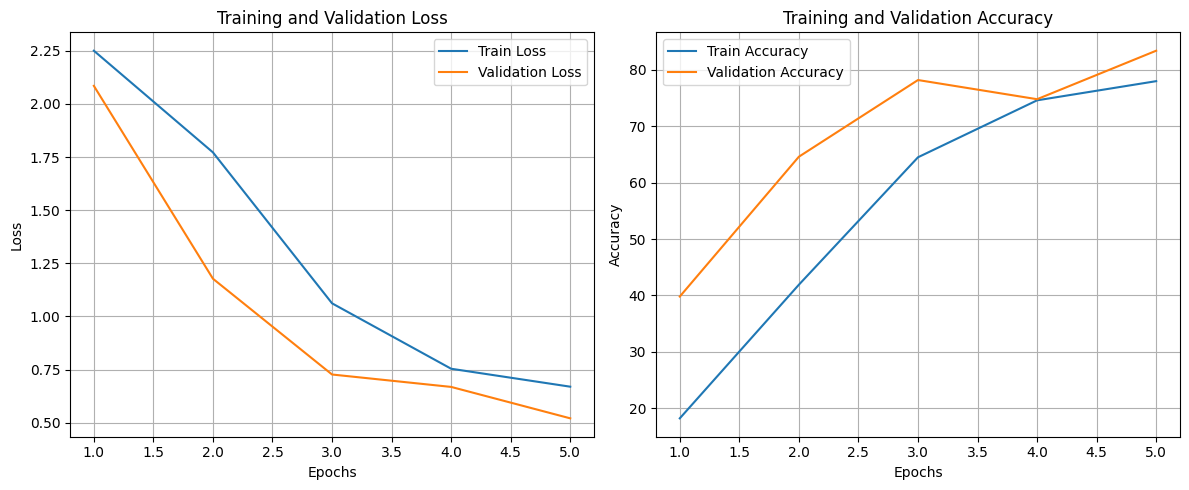

In [ ]:
epochs = range(1, len(history['train_losses']) + 1)

# Plot de losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, history['train_losses'], label='Train Loss')
plt.plot(epochs, history['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot de accuracies
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_model(model, testloader)

Acurácia da rede na base de teste: 82.40%


## Exercícios

### Exercício 1
Na CNN implementada, execute experimentos variando:
- O número de filtros convolucionais em `self.conv1` (6 e 8)
- O número de filtros convolucionais em `self.conv2` (12 e 16)

Ao final, observe qual combinação desempenha melhor no conjunto de testes.

Dica: Adicionar argumentos no construtor da classe para determinar o número de filtros em cada camada pode ser útil para inicializar diversos modelos.

In [ ]:
parametres_combinations = [
    (6,12),
    (6,16),
    (8,12),
    (8,16)
]

for num_filters_1, num_filters_2 in parametres_combinations:
  print(f'Treinamento com {num_filters_1} na primeira camada e {num_filters_2} na segunda camada.')
  model = CNN(
      initialize_weights=True,
      dropout=0.2,
      num_filters_1=num_filters_1,
      num_filters_2=num_filters_2
  )

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

  history = train_model(
      model=model,
      trainloader=trainloader,
      valloader=valloader,
      criterion=criterion,
      optimizer=optimizer
  )

  test_model(model, testloader)
  print()

Treinamento com 6 na primeira camada e 12 na segunda camada.


100%|██████████| 16/16 [00:00<00:00, 21.60it/s]


Epoch 1, Train Loss: 2.250, Train Accuracy: 16.90%
Epoch 1, Val Loss: 2.146, Val Accuracy: 36.40%


100%|██████████| 16/16 [00:00<00:00, 21.75it/s]


Epoch 2, Train Loss: 1.930, Train Accuracy: 37.00%
Epoch 2, Val Loss: 1.438, Val Accuracy: 54.60%


100%|██████████| 16/16 [00:00<00:00, 21.35it/s]


Epoch 3, Train Loss: 1.242, Train Accuracy: 58.50%
Epoch 3, Val Loss: 0.803, Val Accuracy: 77.00%


100%|██████████| 16/16 [00:00<00:00, 21.42it/s]


Epoch 4, Train Loss: 0.762, Train Accuracy: 74.70%
Epoch 4, Val Loss: 0.581, Val Accuracy: 79.00%


100%|██████████| 16/16 [00:00<00:00, 21.12it/s]


Epoch 5, Train Loss: 0.567, Train Accuracy: 81.90%
Epoch 5, Val Loss: 0.510, Val Accuracy: 83.80%
Treinamento concluído
Acurácia da rede na base de teste: 87.40%

Treinamento com 6 na primeira camada e 16 na segunda camada.


100%|██████████| 16/16 [00:00<00:00, 20.65it/s]


Epoch 1, Train Loss: 2.273, Train Accuracy: 17.20%
Epoch 1, Val Loss: 2.180, Val Accuracy: 31.20%


100%|██████████| 16/16 [00:00<00:00, 21.05it/s]


Epoch 2, Train Loss: 1.988, Train Accuracy: 37.10%
Epoch 2, Val Loss: 1.611, Val Accuracy: 63.60%


100%|██████████| 16/16 [00:01<00:00, 15.30it/s]


Epoch 3, Train Loss: 1.216, Train Accuracy: 64.60%
Epoch 3, Val Loss: 0.669, Val Accuracy: 81.60%


100%|██████████| 16/16 [00:01<00:00, 14.01it/s]


Epoch 4, Train Loss: 0.665, Train Accuracy: 77.60%
Epoch 4, Val Loss: 0.477, Val Accuracy: 84.20%


100%|██████████| 16/16 [00:00<00:00, 17.27it/s]


Epoch 5, Train Loss: 0.481, Train Accuracy: 83.70%
Epoch 5, Val Loss: 0.422, Val Accuracy: 87.40%
Treinamento concluído
Acurácia da rede na base de teste: 90.40%

Treinamento com 8 na primeira camada e 12 na segunda camada.


100%|██████████| 16/16 [00:00<00:00, 21.20it/s]


Epoch 1, Train Loss: 2.281, Train Accuracy: 17.10%
Epoch 1, Val Loss: 2.135, Val Accuracy: 30.60%


100%|██████████| 16/16 [00:00<00:00, 20.26it/s]


Epoch 2, Train Loss: 1.886, Train Accuracy: 37.40%
Epoch 2, Val Loss: 1.412, Val Accuracy: 60.40%


100%|██████████| 16/16 [00:00<00:00, 20.52it/s]


Epoch 3, Train Loss: 1.115, Train Accuracy: 61.70%
Epoch 3, Val Loss: 0.667, Val Accuracy: 78.80%


100%|██████████| 16/16 [00:00<00:00, 20.45it/s]


Epoch 4, Train Loss: 0.688, Train Accuracy: 77.10%
Epoch 4, Val Loss: 0.478, Val Accuracy: 83.60%


100%|██████████| 16/16 [00:00<00:00, 21.05it/s]


Epoch 5, Train Loss: 0.441, Train Accuracy: 84.10%
Epoch 5, Val Loss: 0.387, Val Accuracy: 87.80%
Treinamento concluído
Acurácia da rede na base de teste: 90.60%

Treinamento com 8 na primeira camada e 16 na segunda camada.


100%|██████████| 16/16 [00:00<00:00, 20.32it/s]


Epoch 1, Train Loss: 2.250, Train Accuracy: 18.20%
Epoch 1, Val Loss: 2.112, Val Accuracy: 34.80%


100%|██████████| 16/16 [00:00<00:00, 20.43it/s]


Epoch 2, Train Loss: 1.833, Train Accuracy: 45.60%
Epoch 2, Val Loss: 1.417, Val Accuracy: 58.80%


100%|██████████| 16/16 [00:00<00:00, 20.30it/s]


Epoch 3, Train Loss: 1.076, Train Accuracy: 63.70%
Epoch 3, Val Loss: 0.742, Val Accuracy: 78.40%


100%|██████████| 16/16 [00:01<00:00, 15.16it/s]


Epoch 4, Train Loss: 0.591, Train Accuracy: 81.60%
Epoch 4, Val Loss: 0.482, Val Accuracy: 85.60%


100%|██████████| 16/16 [00:01<00:00, 14.32it/s]


Epoch 5, Train Loss: 0.429, Train Accuracy: 84.90%
Epoch 5, Val Loss: 0.404, Val Accuracy: 88.60%
Treinamento concluído
Acurácia da rede na base de teste: 91.60%



O melhor resultado para o conjunto de testes foi a configuração `self.conv1 = 8` e `self.conv2 = 16`. Que gerou uma acurácia de 91,6%.

### Exercício 2

Na CNN implementada, execute 5 treinamentos variando aleatoriamente o número de neurônios de saída em `self.fc1` (o valor atual é 64 e também deve ser alterado na entrada da próxima camada).

Como você determinaria qual foi o melhor valor?

In [ ]:
for i in range(5):
    num_neurons = np.random.randint(10, 300)
    model = model = CNN(
     initialize_weights=True,
     dropout=0.2,
     num_filters_1=8,
     num_filters_2=16,
     num_hidden=num_neurons
     )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    history = train_model(
        model=model,
        trainloader=trainloader,
        valloader=valloader,
        criterion=criterion,
        optimizer=optimizer
    )

    print(f'Número de neurônios na camada fully connected: {num_neurons}')
    test_model(model, testloader)
    print()

100%|██████████| 16/16 [00:01<00:00, 14.51it/s]


Epoch 1, Train Loss: 2.269, Train Accuracy: 15.90%
Epoch 1, Val Loss: 2.180, Val Accuracy: 32.80%


100%|██████████| 16/16 [00:00<00:00, 20.64it/s]


Epoch 2, Train Loss: 1.977, Train Accuracy: 39.70%
Epoch 2, Val Loss: 1.553, Val Accuracy: 61.40%


100%|██████████| 16/16 [00:00<00:00, 21.25it/s]


Epoch 3, Train Loss: 1.174, Train Accuracy: 62.00%
Epoch 3, Val Loss: 0.701, Val Accuracy: 78.20%


100%|██████████| 16/16 [00:00<00:00, 19.95it/s]


Epoch 4, Train Loss: 0.759, Train Accuracy: 74.20%
Epoch 4, Val Loss: 0.545, Val Accuracy: 84.00%


100%|██████████| 16/16 [00:00<00:00, 17.39it/s]


Epoch 5, Train Loss: 0.531, Train Accuracy: 81.10%
Epoch 5, Val Loss: 0.446, Val Accuracy: 86.00%
Treinamento concluído
Número de neurônios na camada fully connected: 78
Acurácia da rede na base de teste: 88.00%



100%|██████████| 16/16 [00:01<00:00, 14.30it/s]


Epoch 1, Train Loss: 2.199, Train Accuracy: 19.60%
Epoch 1, Val Loss: 1.996, Val Accuracy: 37.00%


100%|██████████| 16/16 [00:01<00:00, 15.49it/s]


Epoch 2, Train Loss: 1.623, Train Accuracy: 48.40%
Epoch 2, Val Loss: 0.971, Val Accuracy: 70.40%


100%|██████████| 16/16 [00:00<00:00, 21.06it/s]


Epoch 3, Train Loss: 0.878, Train Accuracy: 71.30%
Epoch 3, Val Loss: 0.565, Val Accuracy: 83.00%


100%|██████████| 16/16 [00:00<00:00, 20.61it/s]


Epoch 4, Train Loss: 0.583, Train Accuracy: 80.20%
Epoch 4, Val Loss: 0.551, Val Accuracy: 82.80%


100%|██████████| 16/16 [00:00<00:00, 20.53it/s]


Epoch 5, Train Loss: 0.478, Train Accuracy: 84.60%
Epoch 5, Val Loss: 0.441, Val Accuracy: 87.20%
Treinamento concluído
Número de neurônios na camada fully connected: 218
Acurácia da rede na base de teste: 89.20%



100%|██████████| 16/16 [00:00<00:00, 20.51it/s]


Epoch 1, Train Loss: 2.216, Train Accuracy: 17.30%
Epoch 1, Val Loss: 2.040, Val Accuracy: 30.40%


100%|██████████| 16/16 [00:00<00:00, 21.10it/s]


Epoch 2, Train Loss: 1.665, Train Accuracy: 47.10%
Epoch 2, Val Loss: 1.246, Val Accuracy: 63.40%


100%|██████████| 16/16 [00:00<00:00, 21.15it/s]


Epoch 3, Train Loss: 0.982, Train Accuracy: 68.60%
Epoch 3, Val Loss: 0.645, Val Accuracy: 80.20%


100%|██████████| 16/16 [00:00<00:00, 21.15it/s]


Epoch 4, Train Loss: 0.629, Train Accuracy: 79.00%
Epoch 4, Val Loss: 0.559, Val Accuracy: 80.40%


100%|██████████| 16/16 [00:00<00:00, 21.40it/s]


Epoch 5, Train Loss: 0.426, Train Accuracy: 86.00%
Epoch 5, Val Loss: 0.442, Val Accuracy: 86.60%
Treinamento concluído
Número de neurônios na camada fully connected: 61
Acurácia da rede na base de teste: 90.00%



100%|██████████| 16/16 [00:01<00:00, 15.22it/s]


Epoch 1, Train Loss: 2.252, Train Accuracy: 18.70%
Epoch 1, Val Loss: 2.124, Val Accuracy: 38.20%


100%|██████████| 16/16 [00:01<00:00, 14.26it/s]


Epoch 2, Train Loss: 1.875, Train Accuracy: 44.20%
Epoch 2, Val Loss: 1.456, Val Accuracy: 59.20%


100%|██████████| 16/16 [00:01<00:00, 14.71it/s]


Epoch 3, Train Loss: 1.137, Train Accuracy: 64.00%
Epoch 3, Val Loss: 0.696, Val Accuracy: 77.00%


100%|██████████| 16/16 [00:00<00:00, 21.42it/s]


Epoch 4, Train Loss: 0.606, Train Accuracy: 78.10%
Epoch 4, Val Loss: 0.566, Val Accuracy: 81.20%


100%|██████████| 16/16 [00:00<00:00, 21.29it/s]


Epoch 5, Train Loss: 0.448, Train Accuracy: 85.90%
Epoch 5, Val Loss: 0.451, Val Accuracy: 86.20%
Treinamento concluído
Número de neurônios na camada fully connected: 276
Acurácia da rede na base de teste: 87.20%



100%|██████████| 16/16 [00:00<00:00, 20.74it/s]


Epoch 1, Train Loss: 2.230, Train Accuracy: 21.20%
Epoch 1, Val Loss: 2.111, Val Accuracy: 34.80%


100%|██████████| 16/16 [00:00<00:00, 20.69it/s]


Epoch 2, Train Loss: 1.845, Train Accuracy: 39.40%
Epoch 2, Val Loss: 1.400, Val Accuracy: 58.20%


100%|██████████| 16/16 [00:00<00:00, 20.19it/s]


Epoch 3, Train Loss: 1.103, Train Accuracy: 64.00%
Epoch 3, Val Loss: 0.654, Val Accuracy: 80.60%


100%|██████████| 16/16 [00:00<00:00, 20.59it/s]


Epoch 4, Train Loss: 0.632, Train Accuracy: 78.80%
Epoch 4, Val Loss: 0.507, Val Accuracy: 84.20%


100%|██████████| 16/16 [00:00<00:00, 20.63it/s]


Epoch 5, Train Loss: 0.469, Train Accuracy: 84.20%
Epoch 5, Val Loss: 0.425, Val Accuracy: 87.40%
Treinamento concluído
Número de neurônios na camada fully connected: 159
Acurácia da rede na base de teste: 89.80%



61 neurônios na camada FC gerou uma acurácia de 90%, mas o padrão do modelo (64 neurônios) gerou uma acurácia de 91,6%.